In [476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi, ceil
from scipy.special import erfinv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randint
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt, log

warnings.filterwarnings("ignore")

In [15]:
def preprocessing(data, method):
    ts_train = []
    ts_valid = []
    ts_test = []
    ts_param = []
    flag_n = False
    flag_diff = False
    flag_dec = False
    if method is 'normalization':
        flag_n = True
    elif method is 'differencing':
        flag_diff = True
            
    for i in range(data.shape[1]):

        temp = list(data.iloc[6:][i].dropna())
        # print(temp)
        if len(temp) > 130:
            
            cut_off_1 = ceil(len(temp)*0.7)
            cut_off_2 = ceil(len(temp)*0.9)

            temp_train = temp[:cut_off_1]
            temp_val = temp[cut_off_1:cut_off_2]
            temp_test = temp[cut_off_2:]

            if flag_n is True:
                ts_param.append([np.mean(temp_train), np.std(temp_train), np.mean(temp_val), 
                np.std(temp_val), np.mean(temp_test), np.std(temp_test)])
                
                temp_train = (temp_train - np.mean(temp_train)) / np.std(temp_train)
                ts_train.append(temp_train)
                

                temp_val = (temp_val - np.mean(temp_val)) / np.std(temp_val)
                ts_valid.append(temp_val)

                temp_test = (temp_test - np.mean(temp_test)) / np.std(temp_test)
                ts_test.append(temp_test)
                

            elif flag_diff is True:

                temp_train = pd.Series(temp_train)
                temp_train_log_diff = temp_train - temp_train.shift()
                temp_train_log_diff[0] = temp_train[0]
                temp_train_log_diff.dropna(inplace=True)
                ts_train.append(temp_train_log_diff.values)

                temp_val = pd.Series(temp_val)
                temp_val_log_diff = temp_val - temp_val.shift()
                temp_val_log_diff[0] = temp_val[0]
                temp_val_log_diff.dropna(inplace=True)
                ts_valid.append(temp_val_log_diff.values)

                temp_test = pd.Series(temp_test)
                temp_test_log_diff = temp_test - temp_test.shift()
                temp_test_log_diff[0] = temp_test[0]
                temp_test_log_diff.dropna(inplace=True)
                ts_test.append(temp_test_log_diff.values)
                
    return ts_train, ts_valid, ts_test, ts_param

# ts_train, ts_valid, ts_test, ts_param = preprocessing(df_temp, method='normalization')

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,-1.631313,-1.509798,-1.820771,-1.811410,-2.256332,-2.192185,-1.749972,-1.813809,-1.384515,-1.279018,...,0.813639,1.496426,1.343573,2.000331,1.262621,1.877523,2.051476,1.293988,1.406663,1.684083
1,0.130996,-0.964424,-1.651968,-2.267606,-1.561751,-1.779186,0.393851,-1.580300,-0.355358,-0.229139,...,0.657919,1.351867,0.189699,1.661272,0.530413,2.606012,2.191458,0.865281,0.959111,1.108358
2,-1.397356,-1.158812,-0.719142,-1.414751,-1.458597,-1.731681,-1.760849,-1.554194,-1.486769,-0.892625,...,0.981367,1.072342,1.753675,1.443347,1.018931,1.845325,1.647179,1.524630,1.617691,1.633418
3,-1.120809,-1.999005,-1.799379,-1.392353,-1.769243,-1.719877,-1.626579,-1.580483,-1.699962,-1.566792,...,0.887166,1.095115,1.441849,1.245200,1.657547,1.717800,2.115424,1.718416,1.280682,1.092503
4,-1.531006,-1.707692,-1.309292,-1.567666,-2.010582,-1.906543,-1.386261,-1.709978,-1.377175,-1.281248,...,1.360433,1.410484,1.640845,1.583427,1.545986,1.613733,1.416117,1.542867,1.387574,1.474332


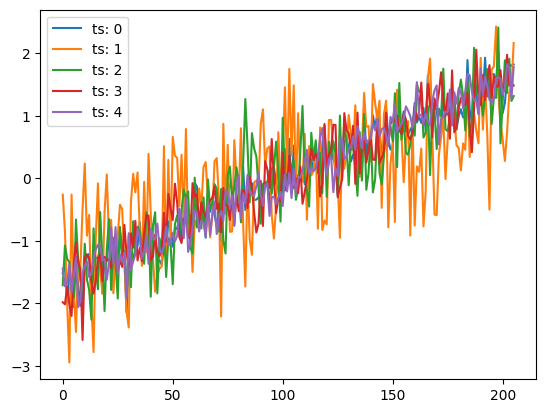

In [470]:
i = 0 
for plot in (np.array(ts_train)):
    # print(plot,i)
    plt.plot(plot, label = 'ts: {}'.format(i))
    i += 1
plt.legend()
plt.show()

In [498]:
def generate_synthetic_data_df_multivar(n_samples=400, n_exog_vars=4):
    """
    Generates a synthetic dataset with a clear relationship between the target and multiple exogenous variables.
    Returns the data as pandas DataFrames.
    """
    exog_data = {}
    
    for i in range(n_exog_vars):
        # Exogenous variable
        exog_data[i] = np.linspace(0, 10*(i+1), n_samples) + np.random.normal(0, 2, n_samples)
    
    # Create a DataFrame for exogenous variables
    exog_df = pd.DataFrame(exog_data)
    
    # Target variable influenced by the sum of exogenous variables with some noise
    target = exog_df.sum(axis=1) + 5 * np.sin(exog_df[0]) + np.random.normal(0, 2, n_samples)
    target_df = pd.DataFrame(target, columns=[0])
    
    return target_df, exog_df

synthetic_target, synthetic_exog = generate_synthetic_data_df_multivar()

In [524]:
class AutoregressiveTree:
    
    def __init__(self, p, u0=0, alpha_u=1, X=None):
        self._X = X  # Exogenous data
        
        erf_temp = np.zeros([7,1])
        for i in range(1,8):
            erf_temp[i-1] = erfinv((i/4) - 1)
        
        self._erf = erf_temp
        self._p = p
        self._alpha_W = p + 2

        self._u0 = u0
        self._alpha_u = alpha_u
        self.target = []
        self.exog = []
    #  calculate the sample mean of the data (could be a vector), maybe split into sample mean of each variable
    def sample_mean(self, data):
        # print(sum(data), len(data))
        return sum(np.asarray(data))/len(data)

    
    # calculate the scatter matrix around the mean uN
    # def scatter_matrix(self, data, uN_):
    def scatter_matrix(self, data, uN_):

        # assert data.shape[1] == p * (1 + no_exog_vars), 'Data dimensions do not match expected shape'
        # Assuming data has been preprocessed to include lags of y and X
        temp = data - uN_

        SN = 0
        for row in temp:
            row = row[:, np.newaxis]
            SN += row * row.T
        # print(len(SN),len(SN[0]))
        return SN
    # def WN_func(self, uN_, SN, W0, N):
    def WN_func(self, uN_, SN, W0, N):
        # assert SN.shape[0] == p * (1 + no_exog_vars), 'Scatter matrix dimensions do not match expected shape'
        temp = self._u0 - uN_

        # Assuming scatter matrix has been computed from preprocessed data
        temp = temp[:, np.newaxis]
        WN = W0 + SN + ((self._alpha_u * N) / (self._alpha_u + N)) * np.dot(temp, temp.T)
        return WN
    # Updates the matrix WN_d, calculates the within node covariance matrix 
    def WN_d_func(self, uN_d_, SN_d_, W0_, N_):
        temp = -uN_d_
        temp = temp[:, np.newaxis]
        WN_ = W0_ + SN_d_ + ((self._alpha_u * N_) / (self._alpha_u + N_)) * np.dot(temp, temp.T)
        return WN_
    # calculating the Maximum a posteriori arameters for the ar model
    def MAP_param(self, N, uN_, WN, q):
        ut = ((self._alpha_u * self._u0) + (N * uN_)) / (self._alpha_u + N)
        div = (self._alpha_W + N - (self._p + 1 + q))
        if div == 0:
            div = 0.00001
        Wt_inv = (1 / div) * WN
        return ut, Wt_inv
    # calculate all of the AR parameters needed 
    def param(self, target, exog):
        # exog = np.array(exog)
        # exog2 = np.reshape(exog.transpose(1, 0, 2), (len(exog[0]), len(exog)*len(exog[0][0])))
        # data = np.hstack((target, exog2))
        self.target, self.exog = target, exog
        
        data = []
        for t, e in zip(target, np.asarray(exog).transpose(1, 0, 2)):
                data.append(np.concatenate([t, e.flatten()]))
        N = len(data)
        q = len(data[0]) -self._p
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        ut, Wt_inv = self.MAP_param(N, uN_, WN, q)
        W = inv(Wt_inv)
        var = abs(1 / W[-1, -1])
        if var > 10:
            var=1
        Wpp = inv(Wt_inv[:-1, :-1])
        # print(Wpp.shape)
        b = np.zeros([len(data[0]), 1])
        for j in range(len(b)-1):
            for i in range(self._p):
                b[j] += Wt_inv[-1, i] * Wpp[i, j]
        b = b[:-1]
        m = ut[-1]
        for i in range(len(b)):
            m += b[i] * ut[i]
        # print(var, m)
        return var, b, m
    # scaling function using the gamma distribution
    def c_func(self, l, alpha):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= gamma((alpha + 1 - i) / 2)
        
        return c
    # probability density scaling function used
    def pds_func(self, N, W0, WN):
        pds = (pi**(-((self._p + 1) * N) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W + N) / self.c_func(self._p + 1, self._alpha_W)) * (det(W0)**(self._alpha_W / 2))*(det(WN)**(-(self._alpha_W + N) / 2))
        return pds
    # similiar to above just now with different params
    def pd_s_func(self, u0_, N_, W0_, WN_):
        pds = (pi**(-((self._p + 1) * N_) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N_))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W - 1 + N_) / self.c_func(self._p + 1, self._alpha_W - 1)) * (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2))
        return pds
    def mult_func(self, l, alpha, N):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= ((alpha + 1 + N - i)/(alpha + 1 - i))
        # print(c)
        return c

    def pds_func2(self, N, W0, WN, u0_, N_, W0_, WN_):

        pds = (det(W0)**(self._alpha_W / 2))*det(WN)**(-(self._alpha_W + N) / 2) / \
        (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2)) * \
        self.mult_func(self._p + 1,self._alpha_W, N)                                                                                                             

        return pds
    def pds_approx(self, N, W0, WN):

        likelihood_val = (self._alpha_u / (self._alpha_u + N))**((self._p + 1) / 2)
        likelihood_val *= (det(W0)**(self._alpha_W / 2))
        likelihood_val *= (det(WN)**(-(self._alpha_W + N) / 2))
        likelihood_val -= self._alpha_W/2 * log(N)
        return likelihood_val
    
    def LeafScore(self, data):
        N = len(data)
        self.target = data
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        # ut, Wt_inv = self.MAP_param(N, uN_, WN, 0)
        data_ = data[:-1]
        N_ = len(data_)
        uN_d_ = self.sample_mean(data_)
        SN_d_ = self.scatter_matrix(data_, uN_d_)
        u0_ = 0
        W0_ = inv(inv(W0))
        WN_d_ = self.WN_d_func(uN_d_, SN_d_, W0_, N_)

        if N > 20:
            # pds2 = self.pds_func2(N, W0, WN, u0_, N_, W0_, WN_d_)
            pds = self.pds_approx(N, W0, WN)
            pds_ = self.pds_approx(N_, W0_, WN_d_)
            pds2 = pds/pds_
        else:
            pds = self.pds_func(N, W0, WN)
            pds_ = self.pd_s_func(u0_, N_, W0_, WN_d_)
            pds2 =  pds/pds_
        
        return pds2
        
    # This will spplit a dataset into two froups based on the specific features. Then splits the data points into the left or right set
    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    def rest_split(self, index, value, train, exog, ex, var):
                # Initializations
        left, right = [], []
        left_e, right_e = [], []
        
        # Convert to DataFrame for easier operations
        train_df = pd.DataFrame(train)
        exog_dfs = [pd.DataFrame(ex) for ex in exog]

        # Split based on exogenous variable
        if ex == "y":
            # Split the specified variable in exog
            for i, row in exog_dfs[var].iterrows():
                if row[index] < value:
                    left_e.append(i)
                else:
                    right_e.append(i)
            if not left_e or not right_e:
                return None, None, None, None
            left_e_index = pd.Index(left_e)
            right_e_index = pd.Index(right_e)

            # Extract corresponding rows from other variables in exog and from train
            left_exog = [df.loc[left_e_index] for df in exog_dfs]
            right_exog = [df.loc[right_e_index] for df in exog_dfs]

            left = train_df.loc[left_e_index]
            right = train_df.loc[right_e_index]

        # Split based on training data
        else:
            for i, row in train_df.iterrows():
                if row[index] < value:
                    left.append(i)
                else:
                    right.append(i)
            if not left or not right:
                return None, None, None, None
            
            left_index = pd.Index(left)
            right_index = pd.Index(right)

            left = train_df.loc[left_index]
            right = train_df.loc[right_index]

            left_exog = [df.loc[left_index] for df in exog_dfs]
            right_exog = [df.loc[right_index] for df in exog_dfs]
        left = left.values.tolist()
        right = right.values.tolist()
        left_exog = [df.values.tolist() for df in left_exog]
        right_exog = [df.values.tolist() for df in right_exog]
        return left, right, left_exog, right_exog
    # itrates through the features and the values to det the best for splitting the dataset, calkculates the score for each split and choses the one with best improvement
    def get_split(self, train, train_exog):
        self.target, self.exog = train, train_exog
        b_index, b_value, b_groups, var = 999, 999, None, 'y'
        b_score = self.LeafScore(train)
        avg = np.mean(train, axis=0)[:-1]
        sigma = np.std(train, axis=0)[:-1]
        split_data = train, train_exog
        for index in range(len(avg)):
            for i in range(len(self._erf)):

                value = avg[index] + sigma[index] * self._erf[i]
                # groups = self.test_split(index, value, train)
                data = self.rest_split(index, value, train, train_exog,"n", 0)
                groups = data[0], data[1]
                if data is None or data[0] is None or data[1] is None:
                    print("NONE TYPE")
                    continue
                new_score = 1
                for group in groups:
                    if len(group) > 1:
                        new_score *= self.LeafScore(group)
            
                        if new_score > b_score:
                            b_index, b_value, b_score, b_groups, var, split_data = index, value, new_score, groups, ("y"+str(index)), data
        j = 0
        bb_score = 1
        for ex in train_exog:
            # print(j)
            self.exog = ex
            avg = np.mean(ex, axis=0)
            min_e = np.min(ex, axis=0)
            max_e = np.max(ex, axis=0)
            self.target = avg
            bb_score =  max(bb_score, self.LeafScore(ex))
            # print(avg)
            sigma = np.std(ex, axis=0)
            for index in range(len(avg)):
                for i in range(len(self._erf)):
                    value = avg[index] + sigma[index] * self._erf[i]
                    if value <= min_e[index] or value >= max_e[index]:
                        continue
                    # groups = self.test_split(index, value, ex)
                    data = self.rest_split(index, value, train, train_exog,"y", j)
                    if data is None or data[2][j] is None or data[3][j] is None:
                        print("NONE TYPE")
                        continue
                    self.target = train
                    self.exog = train_exog
                    groups = data[2][j], data[3][j]
                    
                    new_score = 1
                    for group in groups:
                        if len(group) >1:
                            new_score *= self.LeafScore(group)
                
                            if new_score > b_score:
                                b_index, b_value, b_score, b_groups, var, split_data = index, value, new_score, groups, ("x"+str(j)+str(index)), data
            j += 1
        # print({'index':b_index, 'variable': var, 'value':b_value, 'groups':b_groups})
        # print(var, b_score, bb_score)
        # print(np.asarray(data).shape)
        # self.exog = exog
        return {'index':b_index, 'variable': var, 'value':b_value, 'groups':b_groups, 'split_data':split_data}
    # turns a group of points, belonging to one datagroup into a terminal node, calculates the parameters for that specific group
    def to_terminal(self, target, exog):
        outcomes = self.param(target,exog)
        return outcomes
    # this recursivelky builds the tree up. If the node should be a terminal node make terminal, else use get split to find next best split
    def split(self, node, max_depth, min_size, depth):
        left_t, right_t, left_e, right_e = node['split_data']
        left, right = node['groups']

        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.to_terminal(left_t + right_t, left_e + right_e)
            return
        
        if depth >= max_depth:
            node['left'], node['right'] = self.to_terminal(left_t,left_e ), self.to_terminal(right_t, right_e)
            return
        
        if len(left) <= min_size:
            node['left'] = self.to_terminal(left_t, left_e)
        else:
            node['left'] = self.get_split(left_t, left_e)
            if node['left']['groups'] is None:
                node['left'] = self.to_terminal(left_t, left_e)
            else:
                self.split(node['left'], max_depth, min_size, depth+1)
        
        if len(right) <= min_size:
            node['right'] = self.to_terminal(right_t, right_e)
        else:
            node['right'] = self.get_split(right_t, right_e)
            if node['right']['groups'] is None:
                node['right'] = self.to_terminal(right_t, right_e)
            else:
                self.split(node['right'], max_depth, min_size, depth+1)
    # initiates the buiilding process. Finds initial split and if there are no effective splits then makes source node a terminal node
    def build_tree(self, train, train_exog, max_depth, min_size):
        train=train
        train_exog = train_exog
        root = self.get_split(train, train_exog)
        if root['groups'] is None:
            root['root'] = self.to_terminal(train,train_exog)
            root['index'] = None
            root['value'] = None
            del(root['groups'])
        else:
            # print(root['index'])
            self.split(root, max_depth, min_size, 1)
        
        return root
    # prints the tree structure 
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            if node['value'] is None:
                print(node)
                return                                                                                                                               
            print('%s[%s < %.3f]' % ((depth*' ', (node['variable']), node['value'])))
            # print(depth)
            # print(node)
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
    
        else:
            output = """{} [var: {}
        {} parameters: {}
        {} m: {}]""".format(depth*' ', node[0], depth*' '," ".join(map(str,np.round(np.array(node[1][:]),4).flatten())), depth*' ',  node[2][0])
            print('%s%s' % ((depth*' ', output)))
    # follows the tree strarting from root node until a terminal node is found
    def predict(self, node, row):
        # Expecting the input row to include lags of both y and X
        if 'root' in node:
            return node['root']

        # Determine index based on whether the variable is endogenous or exogenous
        if node['variable'].startswith('y'):
            index = node['index']
        else:
            # Extract the exogenous variable index
            exog_idx = int(node['variable'][1:-1])
            index = self._p + exog_idx  # Adjust for the endogenous variables

        # Navigate the tree based on the comparison
        if row[index] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict(node['right'], row)
            else:
                return node['right']



In [523]:
p = 2
df_temp2 = pd.concat([synthetic_target,synthetic_exog], axis=1)
df_temp2.columns = range(df_temp2.shape[1])

ts_train, ts_valid, ts_test, ts_param = preprocessing(df_temp2, method='normalization')


train = []
for s in ts_train:
    temp = []
    for i in range(len(s) - (p + 1)):
        temp.append(s[i:i + p + 1])
    train.append(temp)
d = train[0]
# print(len(d), len(d[0]))
d_exog = train[1:]
ART = AutoregressiveTree(p)
tree = ART.build_tree(d, d_exog, 10, 10)
ART.print_tree(tree)
# ART.print_tree(tree_list[5])


NONE TYPE
[x02 < 0.811]
 [x00 < 0.625]
  [x10 < 0.220]
   [y1 < -0.216]
    [x10 < -1.390]
     [y1 < -1.463]
             [var: 0.2826469476998798
               parameters: 1.9389 2.0466 -0.3176 -0.5064 -0.6289 0.0767 -0.3869 -0.5207 -0.1344 -0.4974 -0.3937 -0.26 -0.5445 -0.1938
               m: -1.5443936649795353]
      [x31 < -0.845]
       [x32 < -0.932]
        [x30 < -1.443]
                   [var: 0.13834794648945972
                  parameters: 1.4639 1.0185 -0.1555 -0.3245 0.0042 -0.1032 -0.2878 -0.1737 -0.1626 -0.2553 -0.2445 -0.2565 -0.2432 -0.2321
                  m: -1.132689478415459]
                   [var: 0.2587350464907597
                  parameters: 0.9592 0.8228 -0.1209 0.039 0.0119 -0.0977 -0.2603 -0.1143 0.0333 -0.1117 -0.1366 -0.1887 -0.1652 -0.2
                  m: -1.2563658697078033]
                 [var: 0.10229414395528016
                 parameters: 0.6226 0.4297 -0.0458 0.0104 -0.0788 -0.0915 -0.127 -0.1072 -0.0795 -0.0392 -0.0534 -0.0557 -0.07

In [515]:
ART.rest_split(1, -1, ART.target, ART.exog,"y", 1)

KeyError: '[3, 4, 5, 6, 7, 8, 9, 10, 11] not in index'

In [517]:
np.array(ART.exog)

array([[[ 0.81378855,  0.08624245, -0.97520974],
        [ 1.77487149, -0.85654432, -0.41089231],
        [ 0.85411989,  1.18653506, -0.15017237],
        [ 0.62760711, -0.09744464,  0.25155566],
        [ 0.96271137,  0.2109582 , -0.22009455],
        [ 0.77591434, -0.16630193,  0.61219179],
        [ 1.08634484, -0.49988144, -0.19217421],
        [ 1.45598561,  0.5334805 ,  0.46227837],
        [ 1.23184054,  0.02841489,  0.66170038],
        [ 0.8634845 , -0.0592146 ,  0.04254984],
        [ 0.96515666,  0.66728771,  0.57448572],
        [ 0.8632702 ,  0.80275466,  0.36467249]],

       [[-0.5494799 , -1.59815994, -1.31593663],
        [-0.10553685,  0.57136192, -0.70655182],
        [ 0.31051868,  1.14900744,  0.45152738],
        [ 0.39363045,  0.13710009, -0.14489051],
        [ 1.28405035, -0.5088988 ,  1.06209678],
        [ 0.66351124,  0.24014048, -0.23637469],
        [ 0.13055007,  0.09728609,  0.73286456],
        [ 0.82820087,  0.13986143,  0.43839635],
        [ 0.264414

In [503]:
df_temp2 = pd.concat([synthetic_target,synthetic_exog], axis=1)

df_temp2.columns = range(df_temp2.shape[1])

def time_series_pred(data, time_series_index, pred_method, max_p, preprocessing_method):
    ts_train, ts_valid, ts_test, ts_param = preprocessing(df_temp2, method=preprocessing_method)
    p_set = [i for i in range(1,max_p+1)]
    mse_our_model = []
    mse_arima = []
    prediction_input = []
    valid_prediction_list = []
    valid_prediction_list_cumsum = []
    #   Example
    idx = 0
    d_val = ts_valid[0][1:]

    d_test = ts_test[0]
    tree_list = []
    for p in p_set:
            print("tree model with {} lags".format(p))
        # try:
            train = []
            valid = []
            # for s in ts_train:
            #     temp = []                
            #     for i in range(len(s) - (p + 1)):
                    
            # for l in ts_valid:
            #     temp_valid = []
            #     for i in range(len(l) - (p + 1)):
            #         temp_valid.append(l[i:i + p + 1])
            #     valid.append(temp_valid)
            for ind in range(len(ts_train)):
                s, l = ts_train[ind], ts_valid[ind]
                full = np.append(s,l)
                temp = []
                temp_valid = []
                for i in range(len(full)-(p+1)):
                    if i < len(s) - (p + 1):
                        temp.append(full[i:i + p + 1])
                    else:
                        temp_valid.append(full[i:i + p + 1])
                train.append(temp)
                valid.append(temp_valid)
            d = train[0]
            d_exog = train[1:]
            ART = AutoregressiveTree(p)
            tree = ART.build_tree(d, d_exog, 10, 10)
            tree_list.append(tree)
            # tree = tree_list[p-4]
            comb = []
            for t, e in zip(d, np.asarray(d_exog).transpose(1, 0, 2)):
                comb.append(np.concatenate([t, e.flatten()]))
            comb_val = []
            for t, e in zip(valid[0], np.asarray(valid[1:]).transpose(1, 0, 2)):
                comb_val.append(np.concatenate([t, e.flatten()]))
            valid_prediction = []
            valid_window = comb[-1][1:]
            moving_val = ts_train[0]
            for i in range(len(comb_val)-1):
                parameters = ART.predict(tree, valid_window)
                prediction_temp = np.dot(valid_window[:,np.newaxis].T,parameters[1]) + parameters[2]
                valid_prediction.append(prediction_temp[0][0])
                # valid_window = np.append(valid_window, comb_val[i][1:])
                valid_window = comb_val[i][1:]
            valid_prediction_list.append(valid_prediction)
            valid_prediction = pd.Series(valid_prediction, copy=True)
            
            d_val_mean = ts_param[idx][2]
            d_val_std = ts_param[idx][3]
            valid_prediction_denorm= (valid_prediction * d_val_std) + d_val_mean
            valid_prediction_list_cumsum.append(valid_prediction_denorm)
        # except Exception as e:
        #     print(e)
        #     print("p: ", p)
            

    if preprocessing_method is 'normalization':
        d_val_mean = ts_param[idx][2]
        d_val_std = ts_param[idx][3]
        d_val_cumsum = (d_val * d_val_std) + d_val_mean
    else:
        d_val_cumsum = d_val
            
        
    return d_val, d_val_cumsum, valid_prediction_list, valid_prediction_list_cumsum, tree_list, valid_window

# Ground_truth_diff, Ground_truth, valid_prediction_diff_ART_list, valid_prediction_ART_list, tree_list = time_series_pred(data=df_temp2, time_series_index=0, pred_method='ART', max_p=6, preprocessing_method='normalization')

In [525]:
max_p = 5
preprocessing_method = 'normalization'
ts_train, ts_valid, ts_test, ts_param = preprocessing(df_temp2, method=preprocessing_method)
p_set = [i for i in range(1,max_p+1)]
mse_our_model = []
mse_arima = []
prediction_input = []
valid_prediction_list = []
valid_prediction_list_cumsum = []
#   Example
idx = 0
d_val = ts_valid[0][1:]

d_test = ts_test[0]
tree_list = []
for p in p_set:
    # try:
        train = []
        valid = []
        for ind in range(len(ts_train)):
            s, l = ts_train[ind], ts_valid[ind]
            full = np.append(s,l)
            temp = []
            temp_valid = []
            for i in range(len(full)-(p+1)):
                if i < len(s) - (p + 1):
                    temp.append(full[i:i + p + 1])
                else:
                    temp_valid.append(full[i:i + p + 1])
            train.append(temp)
            valid.append(temp_valid)
        d = train[0]
        d_exog = train[1:]
        ART = AutoregressiveTree(p)
        tree = ART.build_tree(d, d_exog, 10, 10)
        tree_list.append(tree)
        # tree = tree_list[p-4]
        comb = []
        for t, e in zip(d, np.asarray(d_exog).transpose(1, 0, 2)):
            comb.append(np.concatenate([t, e.flatten()]))
        comb_val = []
        for t, e in zip(valid[0], np.asarray(valid[1:]).transpose(1, 0, 2)):
            comb_val.append(np.concatenate([t, e.flatten()]))
        valid_prediction = []
        valid_window = comb[-1][1:]
        moving_val = ts_train[0]
        for i in range(len(comb_val)-1):
            parameters = ART.predict(tree, valid_window)
            prediction_temp = np.dot(valid_window[:,np.newaxis].T,parameters[1]) + parameters[2]
            valid_prediction.append(prediction_temp[0][0])
            # valid_window = np.append(valid_window, comb_val[i][1:])
            valid_window = comb_val[i][1:]
        valid_prediction_list.append(valid_prediction)
        valid_prediction = pd.Series(valid_prediction, copy=True)
        
        d_val_mean = ts_param[idx][0]
        d_val_std = ts_param[idx][1]
        valid_prediction_denorm= (valid_prediction * d_val_std) + d_val_mean
        valid_prediction_list_cumsum.append(valid_prediction_denorm)
    # except Exception as e:
    #     print(e)
    #     print("p: ", p)
        

if preprocessing_method is 'normalization':
    d_val_mean = ts_param[idx][0]
    d_val_std = ts_param[idx][1]
    d_val_cumsum = (d_val * d_val_std) + d_val_mean
else:
    d_val_cumsum = d_val

NONE TYPE


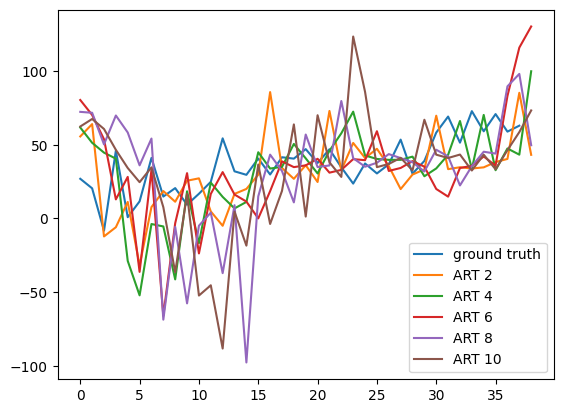

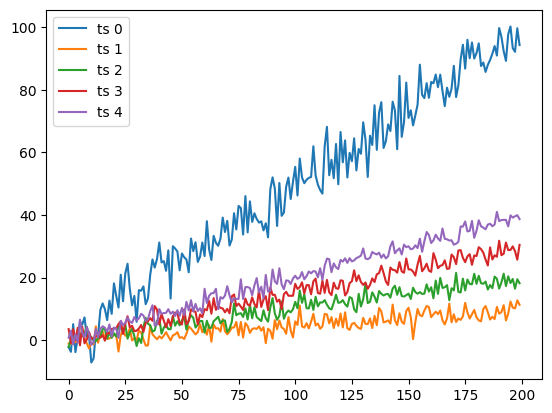

In [325]:
# plt.plot(pd.DataFrame(valid_prediction_list_cumsum).T, label = 'ART')
plt.plot(d_val_cumsum, label = 'ground truth' )
i=1
for plot in (pd.DataFrame(valid_prediction_list_cumsum).to_numpy()):
    if i%2 == 0:
        plt.plot(plot, label="ART {}".format(i))
    i += 1
plt.legend()
plt.show()

for i, val in df_temp2.T.iterrows():
    plt.plot(val, label = "ts {}".format(i))
plt.legend()
plt.show()

In [87]:
def hit_rate(ts_true, ts_pred):
    diff_true = np.diff(ts_true)
    diff_pred = np.diff(ts_pred)
    return np.sum(np.sign(diff_true) == np.sign(diff_pred)) / len(diff_true)

In [530]:
max_p= 8
hit_rate_ART_all_samples = []
hit_rate_AR_all_samples = []
rmse_ART_all_samples = []
rmse_AR_all_samples = []
time_series_index_list = [0,1,2,3,4] #, 786, 396, 276, 614, 377, 101, 124, 62, 35]
# for i in range(0,4):
time_series_index = 0
print('Processing... time series number: ',time_series_index)
time_series_index_list.append(time_series_index)
Ground_truth_diff, Ground_truth, valid_prediction_diff_ART_list, valid_prediction_ART_list, tree, valid_window = time_series_pred(data=df_temp2, 
                                time_series_index=time_series_index, pred_method='ART', max_p=max_p, preprocessing_method='normalization')
# _, _, valid_prediction_diff_AR_list, valid_prediction_AR_list, _ = time_series_pred(data=df3, 
#                                 time_series_index=time_series_index, pred_method='AR', max_p=max_p, preprocessing_method='normalization')

hit_rate_ART_list = []
hit_rate_AR_list = []
rmse_ART_list = []
rmse_AR_list = []
for i in range(max_p):
    hit_rate_ART_list.append(hit_rate(Ground_truth, valid_prediction_ART_list[i]))
    # hit_rate_AR_list.append(hit_rate(Ground_truth, valid_prediction_AR_list[i]))
    rmse_ART_list.append(sqrt(mean_squared_error(Ground_truth, valid_prediction_ART_list[i])))
    # rmse_AR_list.append(sqrt(mean_squared_error(Ground_truth, valid_prediction_AR_list[i])))
hit_rate_ART_all_samples.append(hit_rate_ART_list)
# hit_rate_AR_all_samples.append(hit_rate_AR_list)
rmse_ART_all_samples.append(rmse_ART_list)
# rmse_AR_all_samples.append(rmse_AR_list)

Processing... time series number:  0
NONE TYPE


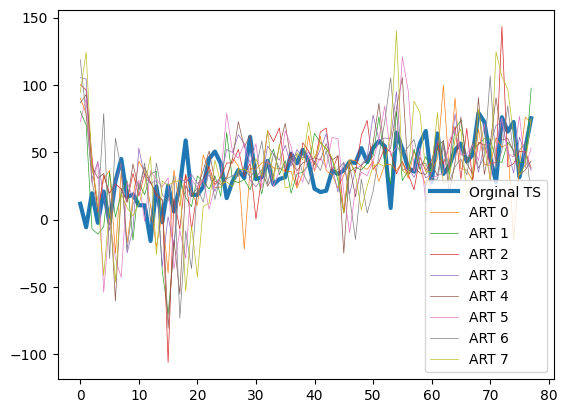

In [539]:
plt.plot(Ground_truth, label = "Orginal TS", linewidth = '3')
for i, pred in enumerate(valid_prediction_ART_list):
    plt.plot(pred, label = "ART {}".format(i), linewidth = '0.5')

plt.legend()
plt.show()

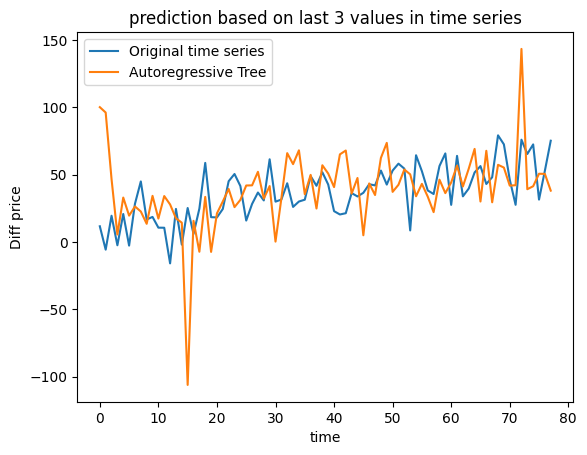

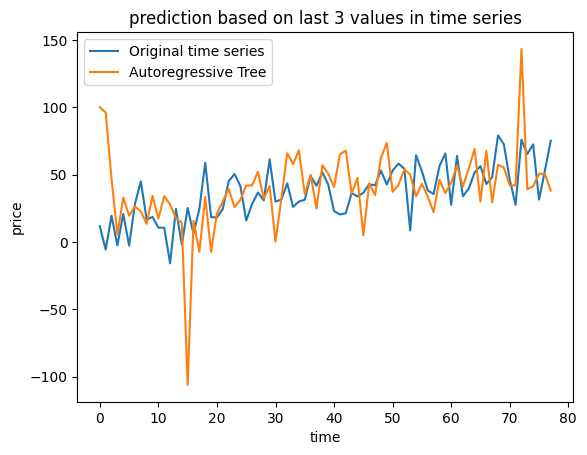

In [533]:
max_hit_rate_index = hit_rate_ART_all_samples[-1].index(max(hit_rate_ART_all_samples[-1]))

plt.plot(Ground_truth, label='Original time series')
plt.plot(valid_prediction_ART_list[max_hit_rate_index], label='Autoregressive Tree')
# plt.plot(valid_prediction_diff_AR_list[max_hit_rate_index], label='AR model')
plt.xlabel('time')
plt.ylabel('Diff price')
i=max_hit_rate_index+1
plt.title('prediction based on last %i values in time series' %i)
plt.legend()
plt.show()
plt.plot(Ground_truth, label='Original time series')
plt.plot(valid_prediction_ART_list[max_hit_rate_index], label='Autoregressive Tree')
# plt.plot(valid_prediction_AR_list[max_hit_rate_index], label='AR model')
plt.xlabel('time')
plt.ylabel('price')
i=max_hit_rate_index+1
plt.title('prediction based on last %i values in time series' %i)
plt.legend()
plt.show()

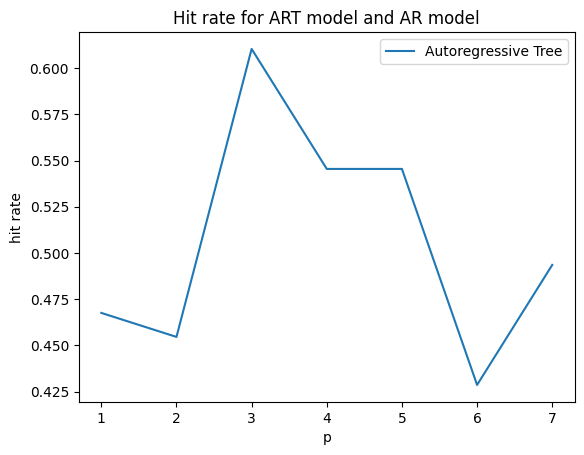

In [541]:
hit_rate_ART_list = np.mean(np.asarray(hit_rate_ART_all_samples), axis=0)
hit_rate_AR_list = np.mean(np.asarray(hit_rate_AR_all_samples), axis=0)

plt.plot(range(1, max_p), hit_rate_ART_list[:-1], label='Autoregressive Tree')
# plt.plot(range(1, max_p), hit_rate_AR_list[:-1], label='AR model')
plt.title('Hit rate for ART model and AR model')
plt.xlabel('p')
plt.ylabel('hit rate')
plt.legend()
plt.show()